In [2]:
from gfactor.main.gfactorsolar import SolarSpectrum

import numpy as np
import pandas as pd
import math
import random

from datetime import date, timedelta
from datetime import datetime as dt

from matplotlib import pyplot as plt
from matplotlib.ticker import FuncFormatter, MaxNLocator, ScalarFormatter
import matplotlib.dates as mdates
import seaborn as sns

import os
from astropy import units as u
from astropy.units import Quantity

### <span style="color:rgb(192, 127, 15);"> Directory </span>

In [3]:
os.chdir("/home/blight25/projects/gfactor")
os.getcwd()

'/home/blight25/projects/gfactor'

### <span style="color:rgb(192, 127, 15);"> Plot Style </span>

In [4]:
sns.set_theme(style="darkgrid", palette="muted")

# <span style="color:rgb(18, 107, 170);"> **<u>Data Loading</u>** </span>

## <span style="color: #12AA83;">SUMER</span>

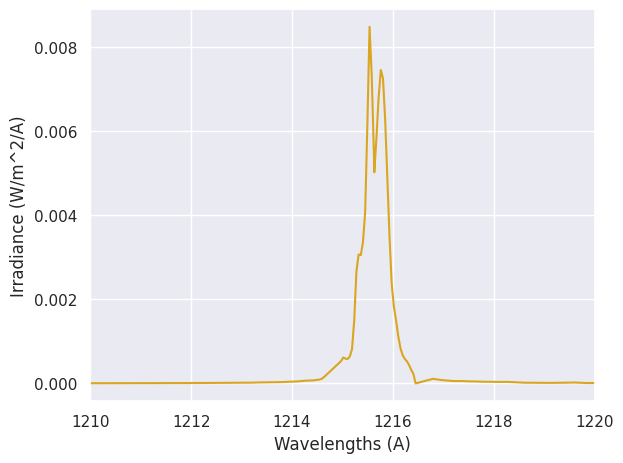

In [5]:
sumer = SolarSpectrum.sumer_spectrum(sumer_file="./spectra/SUMER/SUMER.txt")
fig, ax = plt.subplots()
ax.plot(sumer.spectral_axis, sumer.flux, color="goldenrod")
ax.set_xlabel("Wavelengths (A)")
ax.set_ylabel("Irradiance (W/m^2/A)")
ax.set_xlim(1210, 1220)
fig.tight_layout()
plt.show()

## <span style="color: #12AA83;">NNL</span>

### Single Sample

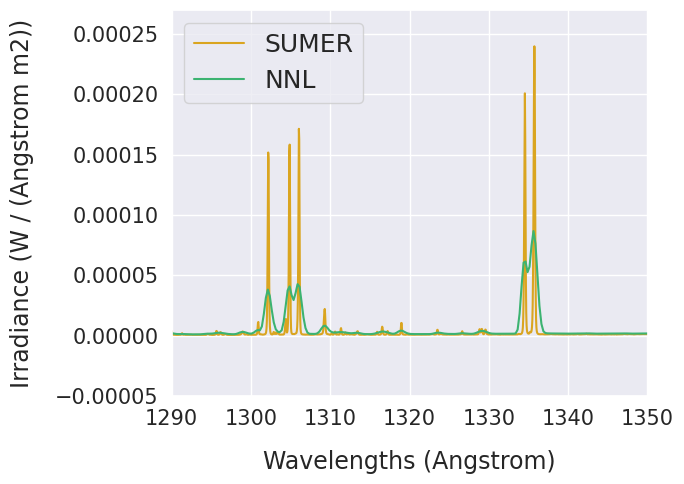

In [6]:
single_date="1997-4-20"
nnl = SolarSpectrum.daily_spectrum(date=single_date, dataset="NNL",
                                   res="high",
                                   daily_dir="./spectra")

# Trim values
sumer, nnl = SolarSpectrum.spectral_overlap(spec1=sumer, spec2=nnl)

fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(sumer.spectral_axis, sumer.flux, color="goldenrod", label="SUMER")
ax.plot(nnl.spectral_axis, nnl.flux, color="mediumseagreen", label="NNL")
ax.set_xlabel(f"Wavelengths ({nnl.spectral_axis.unit})", fontsize=17, labelpad=15)
ax.set_ylabel(f"Irradiance ({nnl.flux.unit})", fontsize=17, labelpad=15)
ax.set_xlim(1290, 1350)
ax.set_ylim(-.00005, .00027)

# Set tick parameters with larger font size
ax.tick_params(axis='both', which='major', labelsize=15)

ax.legend(fontsize=18)
fig.tight_layout()
plt.show()

In [7]:
num_samples = 300
min_date = date(year=1980, month=1, day=1)
max_date = date(year=2023, month=9, day=15)
date_delta = (max_date - min_date).days
deltas = []
delta_set = set()
while len(deltas) < num_samples:
    delta = random.randint(0, date_delta)
    if delta in delta_set:
        continue
    else:
        delta_set.add(delta)
    deltas.append(delta)
deltas = np.array(deltas)
deltas.sort()
dates = [min_date + timedelta(days=int(delta)) for delta in deltas]
dates = [date.strftime("%Y-%m-%d") for date in dates]
nnl_full = [SolarSpectrum.daily_spectrum(date=date, dataset="NNL",
                                    res="high",
                                    daily_dir="./spectra") for date in dates]

min(dates), max(dates)

('1980-01-03', '2023-08-24')

# <span style="color:rgb(18, 107, 170);"> **<u>Fit Procedure</u>** </span>

## <span style="color: #12AA83;">**Build Gaussian Kernels**</span>

In [8]:
OI = [1301, 1303.5]
pixel_stds = [None]*num_samples
for i in range(num_samples):
    _, _, _, pixel_stds[i] = nnl_full[i].feature_fit(fit_func=SolarSpectrum._gaussian_func,
                                                                  feature=OI,     
                                                                  height=1e-5,
                                                                  mean=1302.5,
                                                                  std=.4)

## <span style="color: #12AA83;">**Spectrum Fitting**</span>

In [9]:
outputs_full = [None]*num_samples
outputs_dc_full = [None]*num_samples
for i in range(num_samples):
    outputs_full[i], _, outputs_dc_full[i], _ = SolarSpectrum.daily_fit(poly_degree=5,
                                                                        sumer=sumer,
                                                                        daily_spec=nnl_full[i],
                                                                        gaussian_std = pixel_stds[i])

# <span style="color:rgb(18, 107, 170);"> **<u>Fit Results</u>** </span>

### <span style="color:rgb(192, 127, 15);"> Emissions </span>

In [26]:
emissions = {"1335": [1328.4, 1341], "1405": [1389.65, 1406.4],}

# emissions = {"Lyman-Alpha (1216)": [1208.95, 1221.6], "1335": [1328.4, 1341], 
#              "1400": [1389.65, 1406.4]}

## <span style="color: #12AA83;">**Lyman-Alpha**</span>

### <span style="color:rgb(192, 127, 15);"> Integrated Fluxes, Resolutions, Errors </span>

In [27]:
output_integration_errors_full = dict(zip(emissions.keys(), [None]*len(emissions)))
output_vs_nnl_integration_errors_full = dict(zip(emissions.keys(), [None]*len(emissions)))
output_dc_vs_nnl_integration_errors_full = dict(zip(emissions.keys(), [None]*len(emissions)))

avg_output_integration_error_full = {"Lyman-Alpha":None, "1302 OI Triplet":None, "1562 CI":None}
avg_output_vs_nnl_integration_error_full = {"Lyman-Alpha":None, "1302 OI Triplet":None, "1562 CI":None}
avg_output_dc_vs_nnl_integration_error_full = {"Lyman-Alpha":None, "1302 OI Triplet":None, "1562 CI":None}

max_output_integration_error_full = {"Lyman-Alpha":None, "1302 OI Triplet":None, "1562 CI":None}
max_output_vs_nnl_integration_error_full = {"Lyman-Alpha":None, "1302 OI Triplet":None, "1562 CI":None}
max_output_dc_vs_nnl_integration_error_full = {"Lyman-Alpha":None, "1302 OI Triplet":None, "1562 CI":None}

sumer.emissions = emissions
for key in list(emissions.keys()):
    output_integration_errors_full[key] = np.zeros(num_samples)
    output_vs_nnl_integration_errors_full[key] = np.zeros(num_samples)
    output_dc_vs_nnl_integration_errors_full[key] = np.zeros(num_samples)
    for i in range(num_samples):
        nnl_full[i].emissions = emissions
        outputs_full[i].emissions = emissions
        outputs_dc_full[i].emissions = emissions

        # Errors
        output_integration_errors_full[key][i] = math.fabs((outputs_dc_full[i].emissions[key]["Integrated Flux"] - \
                                        outputs_full[i].emissions[key]["Integrated Flux"]) / outputs_full[i].emissions[key]["Integrated Flux"]) * 100
        
        output_vs_nnl_integration_errors_full[key][i] = math.fabs((outputs_full[i].emissions[key]["Integrated Flux"] - \
                                        nnl_full[i].emissions[key]["Integrated Flux"]) / nnl_full[i].emissions[key]["Integrated Flux"]) * 100
        
        output_dc_vs_nnl_integration_errors_full[key][i] = math.fabs((outputs_dc_full[i].emissions[key]["Integrated Flux"] - \
                                        nnl_full[i].emissions[key]["Integrated Flux"]) / nnl_full[i].emissions[key]["Integrated Flux"]) * 100


    avg_output_integration_error_full[key] = np.mean(output_integration_errors_full[key])
    avg_output_vs_nnl_integration_error_full[key] = np.mean(output_vs_nnl_integration_errors_full[key])
    avg_output_dc_vs_nnl_integration_error_full[key] = np.mean(output_dc_vs_nnl_integration_errors_full[key])

In [28]:
for key in list(emissions.keys()):
    print(f"\n{key} Errors")
    print(f"Average model integration error: {avg_output_integration_error_full[key]:.2f}%")
    print(f"Average model vs NNL integration error: {avg_output_vs_nnl_integration_error_full[key]:.2f}%")
    print(f"Average m(model) vs NNL integration error: {avg_output_dc_vs_nnl_integration_error_full[key]:.2f}%")


1335 Errors
Average model integration error: 2.23%
Average model vs NNL integration error: 10.33%
Average m(model) vs NNL integration error: 7.87%

1405 Errors
Average model integration error: 1.37%
Average model vs NNL integration error: 3.41%
Average m(model) vs NNL integration error: 2.68%


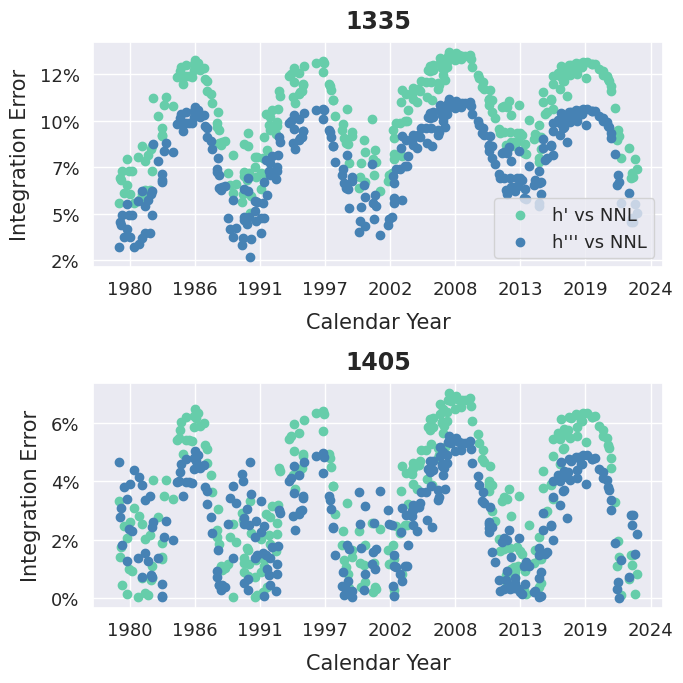

In [37]:
fig, axs = plt.subplots(len(emissions), 1, figsize=(7, 7))

def integer_formatter(x, pos):
    return f'{int(x)}'

def percentage_formatter(x, pos):
    return f'{int(x)}%'

plot_dates = [dt.strptime(date, "%Y-%m-%d").date() for date in dates]
for i, key in enumerate(list(emissions.keys())):
   #axs[i].scatter(dates, output_integration_errors_full[key], color="royalblue", label="Output Integration Error")
    axs[i].scatter(plot_dates, output_vs_nnl_integration_errors_full[key], color="mediumaquamarine", label="h' vs NNL")
    axs[i].scatter(plot_dates, output_dc_vs_nnl_integration_errors_full[key], color="steelblue", label="h''' vs NNL")
    axs[i].set_title(f"{key}", fontsize=17, fontweight="bold", pad=10)
    axs[i].set_xlabel("Calendar Year", fontsize=15, labelpad=10)
    axs[i].set_ylabel("Integration Error", fontsize=15, labelpad=7)
    axs[i].tick_params(axis='both', which='major', labelsize=13)
    axs[i].yaxis.set_major_formatter(FuncFormatter(integer_formatter))
    axs[i].yaxis.set_major_formatter(FuncFormatter(percentage_formatter))
    axs[i].xaxis.set_major_locator(MaxNLocator(nbins=10))
    axs[i].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

axs[0].legend(fontsize=13)
fig.tight_layout()
plt.show()

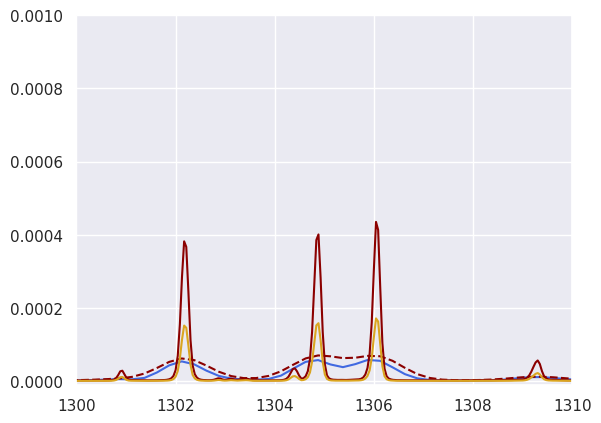

In [14]:
plt.plot(nnl_full[0].spectral_axis, nnl_full[0].flux, color="royalblue")
plt.plot(outputs_full[0].spectral_axis, outputs_full[0].flux, color="darkred")
plt.plot(outputs_dc_full[0].spectral_axis, outputs_dc_full[0].flux, color="darkred", linestyle="--")
plt.plot(sumer.spectral_axis, sumer.flux, color="goldenrod")
plt.xlim(1300, 1310)
plt.ylim(-1e-5, 1e-3)
plt.show()

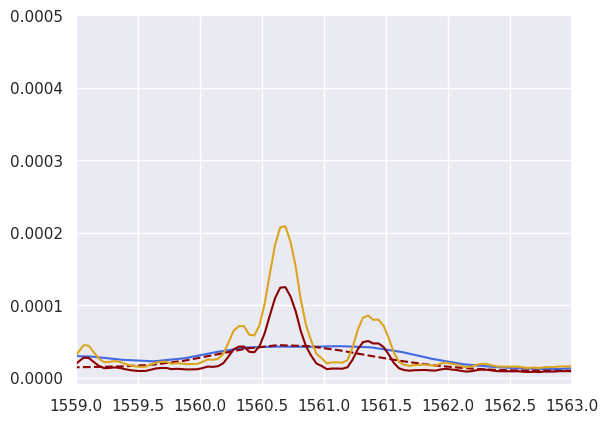

In [15]:
plt.plot(nnl_full[0].spectral_axis, nnl_full[0].flux, color="royalblue")
plt.plot(outputs_full[0].spectral_axis, outputs_full[0].flux, color="darkred")
plt.plot(outputs_dc_full[0].spectral_axis, outputs_dc_full[0].flux, color="darkred", linestyle="--")
plt.plot(sumer.spectral_axis, sumer.flux, color="goldenrod")
plt.xlim(1559, 1563)
plt.ylim(-1e-5, 5e-4)
plt.show()